In [5]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [65]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id="cid",
    client_secret="c_Sec",
    redirect_uri="http://localhost:9090/callback/",
    scope="user-read-recently-played user-top-read",
    open_browser=False  # Prevents opening a local server
))


In [9]:
results = sp.current_user_recently_played(limit=50)

# Extract relevant track data
tracks = []
for item in results['items']:
    track = item['track']
    tracks.append({
        "Track Name": track['name'],
        "Artist": track['artists'][0]['name'],
        "Played At": item['played_at']
    })

# Convert to DataFrame
df = pd.DataFrame(tracks)
df.to_csv("spotify_listening_history.csv", index=False)
print("Data saved successfully!")


Go to the following URL: https://accounts.spotify.com/authorize?client_id=cd434f92b1804b478956c97d974b35c9&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A9090%2Fcallback%2F&scope=user-read-recently-played
Enter the URL you were redirected to:  http://localhost:9090/callback/?code=AQD3YBkb17OvLBzEq_chMdaAbP_YMidLqQewjukiohC07SK_ceFz5vKBAZtqj2_caIy15dh4DlhWi26XT24aYf03SIiBmTYHs8UFlOJZ9jCSWsxoZd7OugwlPU0odSbEQ0TuWLfkIYKSfrqE7NS-CVJxmkmHX4-d9P2ZnyXK7JDFfwSjTw_eBD0D6RsadlEhGhWosA-g5zcFM7U1Lp8


Data saved successfully!


In [11]:
# Load the saved CSV
df = pd.read_csv("spotify_listening_history.csv")

# Convert 'Played At' to datetime format
df["Played At"] = pd.to_datetime(df["Played At"])

# Extract useful time features
df["Hour"] = df["Played At"].dt.hour
df["Day"] = df["Played At"].dt.day_name()

# Show first few rows
df.head()


,Track Name,Artist,Played At,Hour,Day
0,Bura / Bhala,Yashraj,2025-02-21 04:40:02.983000+00:00,4,Friday
1,Swah!,Seedhe Maut,2025-02-21 04:36:07.124000+00:00,4,Friday
2,Namastute,Seedhe Maut,2025-02-21 04:23:10.932000+00:00,4,Friday
3,BAWE MAIN CHECK,King,2025-02-21 04:21:10.190000+00:00,4,Friday
4,Woh Raat,Raftaar,2025-02-21 04:18:02.173000+00:00,4,Friday


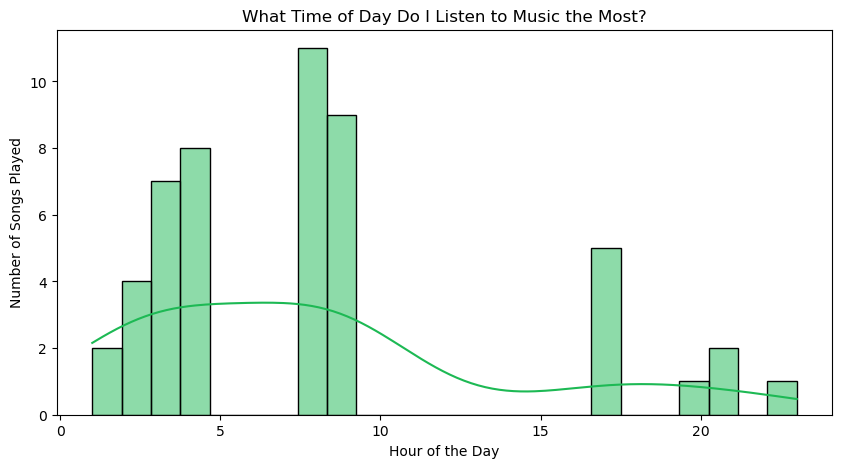

In [53]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Hour"], bins=24, kde=True, color="#1DB954")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Songs Played")
plt.title("What Time of Day Do I Listen to Music the Most?")
plt.show()


/var/folders/yb/5k_lxzt100d7tw6hcft3_v9r0000gn/T/ipykernel_71733/610426985.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette=spotify_palette)
/var/folders/yb/5k_lxzt100d7tw6hcft3_v9r0000gn/T/ipykernel_71733/610426985.py:8: UserWarning: 
The palette list has fewer values (7) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=top_artists.values, y=top_artists.index, palette=spotify_palette)


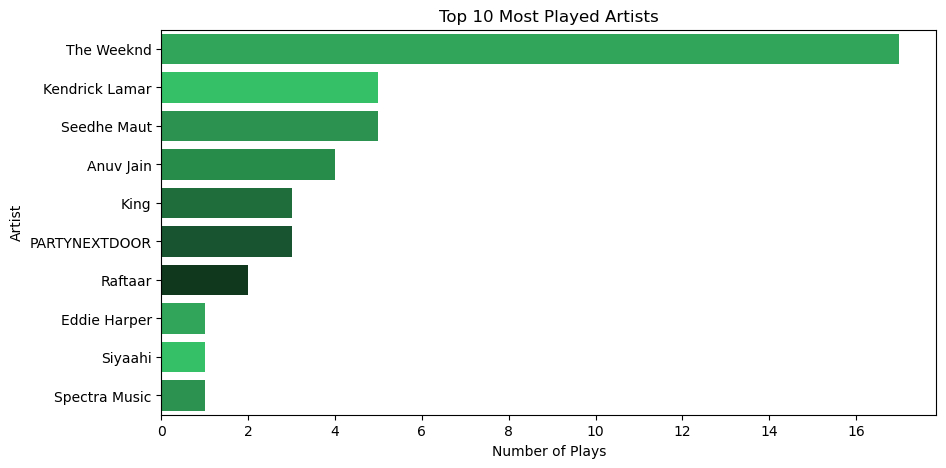

In [57]:
spotify_palette = ["#1DB954", "#1ed760", "#1aa34a", "#169c45", "#117a37", "#0e5e2d", "#083f1b"]

# Set the color palette globally for Seaborn
sns.set_palette(spotify_palette)

plt.figure(figsize=(10, 5))
top_artists = df["Artist"].value_counts().head(10)
sns.barplot(x=top_artists.values, y=top_artists.index, palette=spotify_palette)
plt.xlabel("Number of Plays")
plt.ylabel("Artist")
plt.title("Top 10 Most Played Artists")
plt.show()


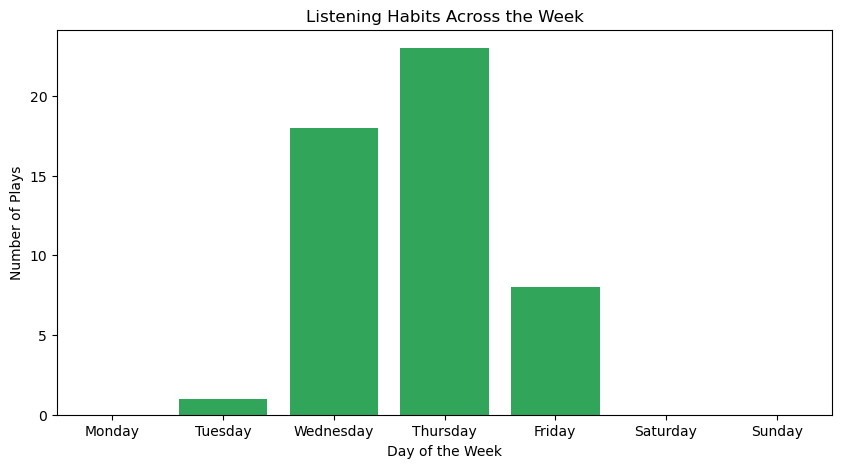

In [59]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df["Day"], order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Day of the Week")
plt.ylabel("Number of Plays")
plt.title("Listening Habits Across the Week")
plt.show()


In [31]:
# Convert 'Played At' to datetime (if not already done)
df["Played At"] = pd.to_datetime(df["Played At"])

# Sort data chronologically
df = df.sort_values(by="Played At")

# Create "Session ID" based on 30-minute gaps
df["Time Difference"] = df["Played At"].diff().dt.total_seconds().fillna(0)
df["Session"] = (df["Time Difference"] > 1800).cumsum()

# Count how many tracks per session
session_lengths = df.groupby("Session")["Track Name"].count()

# Find most played day of the week
most_played_day = df["Day"].value_counts().idxmax()

# Find repeated songs
df["Repeated"] = df.duplicated(subset=["Track Name", "Artist"], keep=False)


In [33]:
# Aggregate number of songs played per day
df["Date"] = df["Played At"].dt.date
daily_listening = df.groupby("Date")["Track Name"].count()

# Rolling average to smooth trends
df["7-Day Avg"] = daily_listening.rolling(window=7).mean()


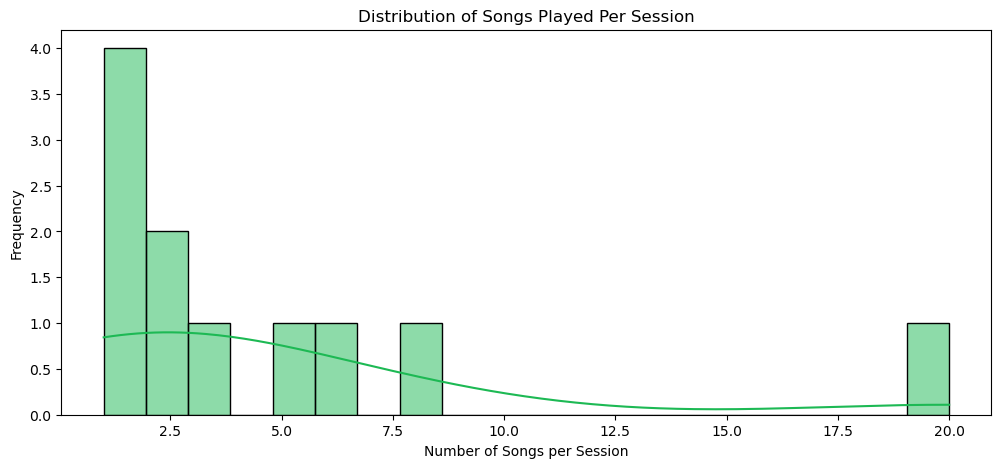

In [61]:
plt.figure(figsize=(12, 5))
sns.histplot(session_lengths, bins=20, kde=True)
plt.xlabel("Number of Songs per Session")
plt.ylabel("Frequency")
plt.title("Distribution of Songs Played Per Session")
plt.show()


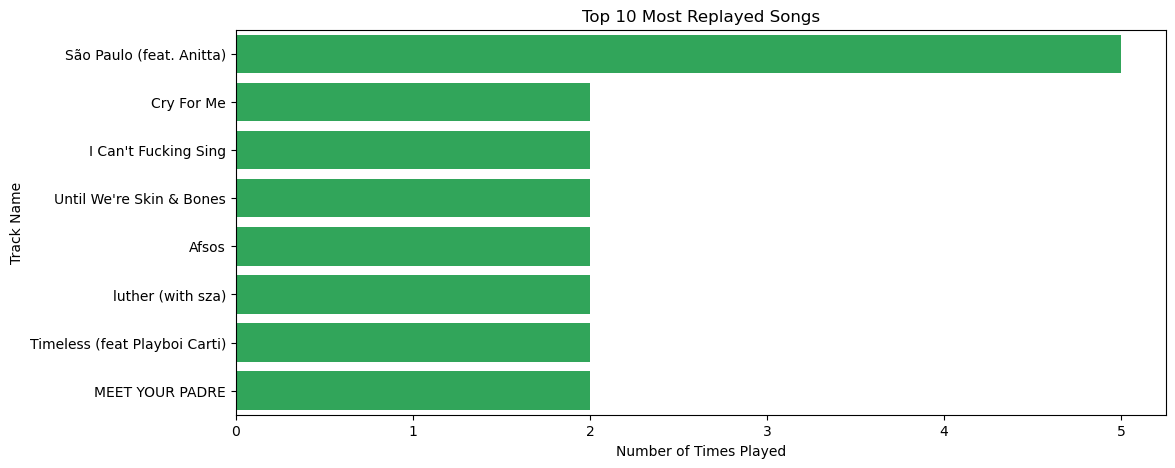

In [63]:
plt.figure(figsize=(12, 5))
repeat_counts = df[df["Repeated"]]["Track Name"].value_counts().head(10)
sns.barplot(y=repeat_counts.index, x=repeat_counts.values)
plt.xlabel("Number of Times Played")
plt.ylabel("Track Name")
plt.title("Top 10 Most Replayed Songs")
plt.show()


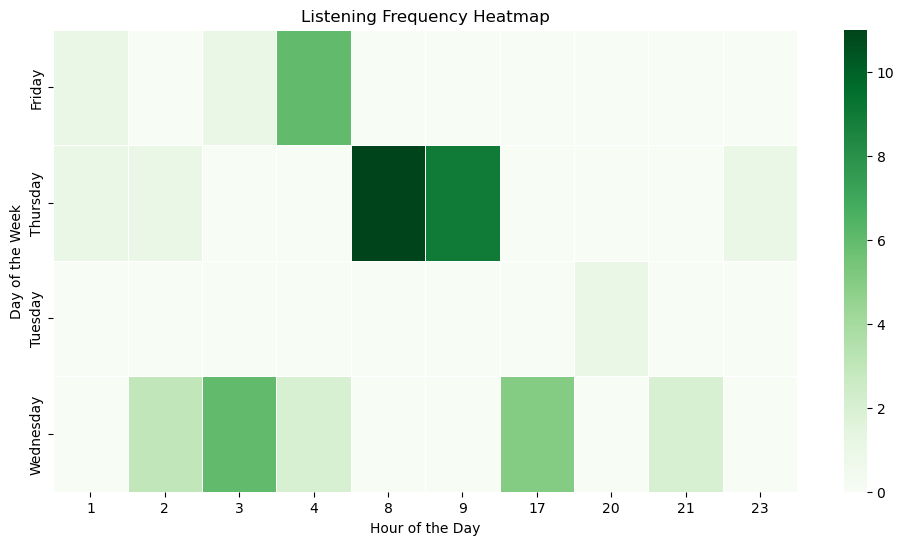

In [51]:
df["Hour"] = df["Played At"].dt.hour
df["Day"] = df["Played At"].dt.day_name()

# Pivot table for heatmap
heatmap_data = df.pivot_table(index="Day", columns="Hour", values="Track Name", aggfunc="count").fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Greens", linewidths=0.5)
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.title("Listening Frequency Heatmap")
plt.show()
